<a href="https://colab.research.google.com/github/Soham3012/SLM_from_scratch/blob/main/SLMfromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U datasets
! pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [ ]:
from datasets import load_dataset

In [ ]:
import tiktoken
import numpy as np
import os
from tqdm.auto import tqdm
import torch

In [ ]:
ds=load_dataset("roneneldan/TinyStories")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [ ]:
enc=tiktoken.get_encoding("gpt2")
def process(example):
  ids=enc.encode_ordinary(example["text"])
  out={'ids':ids, 'len':len(ids)}
  return out
if not os.path.exists("train.bin"):
  tokenized=ds.map(process,
                   remove_columns=['text'],
                   desc="tokenizing the splits",
                   num_proc=8,)
  for split,dset in tokenized.items():
    arr_len=np.sum(dset["len"], dtype=np.uint64)
    filename=f"{split}.bin"
    dtype=np.uint16
    arr=np.memmap(filename,dtype=dtype,mode="w+",shape=(arr_len,))
    total_batches=1024

    idx=0
    for batch_idx in tqdm(range(total_batches),desc=f"writing {filename}"):
      batch=dset.shard(num_shards=total_batches,index=batch_idx,contiguous=True).with_format("numpy")
      arr_batch=np.concatenate(batch["ids"])
      arr[idx : idx + len(arr_batch)] = arr_batch
      idx += len(arr_batch)
    arr.flush()

tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

Create Input-Output pairs

In [ ]:
def get_batch(split):
  if split=='train':
    data=np.memmap("train.bin",dtype=np.uint16,mode="r")
  else:
    data=np.memmap("validation.bin",dtype=np.uint16,mode="r")
  ix=torch.randint(len(data)-block_size,(batch_size,))
  x=torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
  y=torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
  if device_type == 'cuda':
    x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
  else:
    x, y = x.to(device), y.to(device)
  return x,y

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

In [ ]:
class LayerNorm (nn.Module):
  def __init__(self, ndim,bias):
    super().__init__()
    self.weight=nn.Parameter(torch.ones(ndim))
    self.bias=nn.Parameter(torch.zeros(ndim) if bias else None)
  def forward(self,x):
    return F.layer_norm(x,self.weight.shape, self.weight, self.bias,1e-5)

class CausalSelfAttention(nn.Module):
  def __init__(self,config):
    super().__init__()
    assert config.n_embd%config.n_head==0
    self.c_attn=nn.Linear(config.n_embd,3*config.n_embd,bias=config.bias)
    self.c_proj=nn.Linear(config.n_embd,config.n_embd,bias=config.bias)
    self.attn_dropout=nn.Dropout(config.dropout)
    self.resid_dropout=nn.Dropout(config.dropout)
    self.n_head=config.n_head
    self.n_embd=config.n_embd
    self.flash=hasattr(F,'scaled_dot_product_attention')
    if not self.flash:
      self.register_buffer("bias",torch.tril(torch.ones(config.block_size,config.block_size)).view(1,1,config.block_size,config.block_size))
  def forward(self,x):
    B,T,C=x.size()
    q,k,v=self.c_attn(x).split(self.n_embd,dim=2)
    k=k.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
    q=q.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
    v=v.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
    if self.flash:
      y=F.scaled_dot_product_attention(q,k,v,attn_mask=None,dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
    else:
      att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
      att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
      att = F.softmax(att, dim=-1)
      att = self.attn_dropout(att)
      y = att @ v
    y=y.transpose(1,2).contiguous().view(B,T,C)
    y=self.resid_dropout(self.c_proj(y))
    return y

class MLP(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.c_fc=nn.Linear(config.n_embd,4*config.n_embd,bias=config.bias)
    self.gelu=nn.GELU()
    self.c_proj=nn.Linear(4*config.n_embd,config.n_embd,bias=config.bias)
    self.dropout=nn.Dropout(config.dropout)
  def forward(self,x):
    return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.ln1=LayerNorm(config.n_embd,bias=config.bias)
    self.attn=CausalSelfAttention(config)
    self.ln2=LayerNorm(config.n_embd,bias=config.bias)
    self.mlp=MLP(config)
  def forward(self,x):
    x = x + self.attn(self.ln1(x))
    x = x + self.mlp(self.ln2(x))
    return x


In [ ]:
from logging import log
@dataclass
class GPTConfig:
  block_size:int
  vocab_size:int
  n_layer:int
  n_head:int
  n_embd:int
  dropout:float
  bias:bool
class  GPT(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.config=config
    self.transformer=nn.ModuleDict(dict(
      wte=nn.Embedding(config.vocab_size,config.n_embd),
      wpe=nn.Embedding(config.block_size,config.n_embd),
      drop=nn.Dropout(config.dropout),
      h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
      ln_f=LayerNorm(config.n_embd,bias=config.bias),
    ))
    self.lm_head=nn.Linear(config.n_embd, config.vocab_size, bias=False)
    self.transformer.wte.weight=self.lm_head.weight

    self.apply(self.__init_weights)
    for pn,p in self.named_parameters():
      if pn.endswith('c_proj.weight'):
        torch.nn.init.normal_(p,mean=0.0,std=0.02/math.sqrt(2*config.n_layer))
  def __init_weights(self,module):
    if isinstance(module,nn.Linear):
      nn.init.normal_(module.weight,mean=0.0,std=0.02)
      if module.bias is not None:
        nn.init.zeros_(module.bias)
    elif isinstance(module,nn.Embedding):
      nn.init.normal_(module.weight,mean=0.0,std=0.02)
  def forward(self,idx,targets=None):
    device=idx.device
    b,t=idx.size()
    assert t<=self.config.block_size
    pos=torch.arange(0,t,dtype=torch.long,device=device)

    tok_emb=self.transformer.wte(idx)
    pos_emb=self.transformer.wpe(pos)
    x=self.transformer.drop(tok_emb+pos_emb)
    for block in self.transformer.h:
      x=block(x)
    x=self.transformer.ln_f(x)

    if targets is not None:
      logits=self.lm_head(x)
      loss=F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1),ignore_index=-1)
      return logits,loss
    else:
      logits=self.lm_head(x)
      return logits,None
  @torch.no_grad()
  def generate(self,idx,max_new_tokens,temperature=1.0,top_k=None):
    '''Generate tokens given a sequence
    idx: Tensor of shape (B,T)
    '''
    for _ in range(max_new_tokens):
      idx_cond=idx if idx.size(1)<=self.config.block_size else idx[:,-self.config.block_size:]
      logits,_=self(idx_cond)
      logits=logits[:,-1,:]/temperature
      if top_k is not None:
        v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
        logits[logits < v[:, [-1]]] = -float('Inf')
      probs=F.softmax(logits,dim=-1)
      idx_next=torch.multinomial(probs,num_samples=1)
      idx=torch.cat((idx,idx_next),dim=1)
    return idx


In [ ]:
config= GPTConfig(
     block_size = 128,
     vocab_size =50527,
     n_layer = 6,
     n_head = 6,
     n_embd =384,
     dropout=0.1,
     bias=True
)
model=GPT(config)

In [ ]:
def estimate_loss(model):
  out={}
  model.eval()
  with torch.inference_mode():
    for split in ['train','val']:
      losses=torch.zeros(eval_iters)
      for k in range(eval_iters):
        X,Y=get_batch(split)
        with ctx:
          logits, loss=model(X,Y)
        losses[k]=loss.item()
      out[split]=losses.mean()
    model.train()
    return out

In [ ]:
learning_rate=1e-4
max_iters=20000
warmup_steps=1000
min_lr=5e-4
eval_iters=500
batch_size=32
block_size=128

gradient_accumulation_steps=32

device ="cuda" if torch.cuda.is_available() else "cpu"
device_type= "cuda" if "cuda" in device else "cpu"

dtype='bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype={'float32':torch.float32,'bfloat16':torch.bfloat16,'float16':torch.float16}[dtype]

ctx=nullcontext() if device_type=='cpu' else torch.amp.autocast(device_type=device_type,dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)


In [ ]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR,CosineAnnealingLR

optimizer= torch.optim.AdamW(model.parameters(),lr=learning_rate,betas=(0.9,0.95),weight_decay=0.1, eps=1e-9)

scheduler_warmup=LinearLR(optimizer,total_iters=warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer,T_max=max_iters-warmup_steps, eta_min=min_lr)
scheduler = SequentialLR(optimizer,schedulers=[scheduler_warmup,scheduler_decay],milestones=[warmup_steps])

scaler=torch.cuda.amp.GradScaler(enabled=(dtype=='float16'))

<ipython-input-13-2978912628>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=torch.cuda.amp.GradScaler(enabled=(dtype=='float16'))


In [ ]:
best_val_loss= float('inf')
best_model_params_path="best_model_params.pt"
train_loss_list, validation_loss_list=[],[]

model=model.to(device)

for epoch in tqdm(range(max_iters)):
  if epoch % eval_iters==0 and epoch!=0:
    losses=estimate_loss(model)
    print(f"step {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    print(f"The current learning rate : {optimizer.param_groups[0]['lr']:.5f}")
    # train_loss_list += [losses['train']]
    # validation_loss_list += [losses['val']]

    if losses['val']<best_val_loss:
      best_val_loss=losses['val']
      torch.save(model.state_dict(),best_model_params_path)
    train_loss=losses['train'].item()
    val_loss=losses['val'].item()
    train_loss_list.append(train_loss)
    validation_loss_list.append(val_loss)


  X,y=get_batch("train")
  X,y=X.to(device),y.to(device)

  with ctx:
    logits, loss =model(X,y)
    loss=loss/gradient_accumulation_steps
    scaler.scale(loss).backward()
  if ((epoch+1)%gradient_accumulation_steps==0) or (epoch+1==max_iters):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none=True)
  scheduler.step()

  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


step 500: train loss 9.3873, val loss 9.3937
The current learning rate : 0.00007


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


step 1000: train loss 8.4428, val loss 8.4481
The current learning rate : 0.00010
step 1500: train loss 7.4916, val loss 7.4929
The current learning rate : 0.00010
step 2000: train loss 6.6439, val loss 6.6401
The current learning rate : 0.00010
step 2500: train loss 5.9551, val loss 5.9482
The current learning rate : 0.00011
step 3000: train loss 5.4492, val loss 5.4516
The current learning rate : 0.00011
step 3500: train loss 5.0383, val loss 5.0373
The current learning rate : 0.00012
step 4000: train loss 4.7275, val loss 4.7244
The current learning rate : 0.00012
step 4500: train loss 4.4872, val loss 4.4913
The current learning rate : 0.00013
step 5000: train loss 4.2756, val loss 4.2843
The current learning rate : 0.00014
step 5500: train loss 4.1239, val loss 4.1219
The current learning rate : 0.00015
step 6000: train loss 3.9632, val loss 3.9641
The current learning rate : 0.00016
step 6500: train loss 3.8237, val loss 3.8288
The current learning rate : 0.00018
step 7000: train

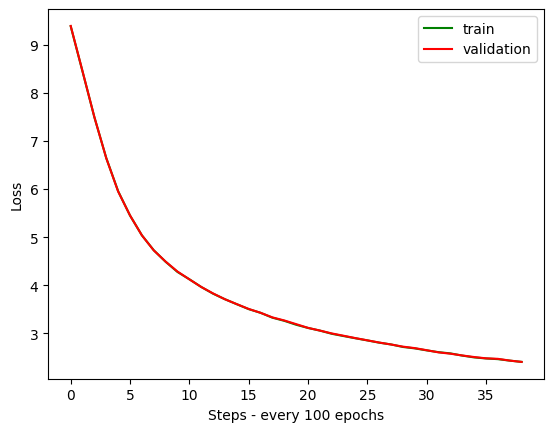

In [ ]:
import matplotlib.pyplot as plt
train_loss_list_converted=[i for i in train_loss_list]
validation_loss_list_converted=[i for i in validation_loss_list]
plt.plot(train_loss_list_converted,'g',label='train')
plt.plot(validation_loss_list_converted,'r',label='validation')
plt.xlabel("Steps - every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model=GPT(config)
device= "cuda" if  torch.cuda.is_available() else cpu
print(device)
best_model_params_path="best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location= torch.device(device)))

cuda


<All keys matched successfully>

In [ ]:
sentence="Once upon a time there was a chess grandmaster."
context=(torch.tensor(enc.encode(sentence),dtype=torch.long,device=device)).unsqueeze(dim=0)
y=model.generate(context,max_new_tokens=200,temperature=1.0,top_k=None)
print(enc.decode(y[0].tolist()))


Once upon a time there was a chess grandmaster. She was very important. It was very important than everyone who wanted to talk to someone in. One day a little ponds became good at the jungle. All of the other animals in the garden "Oh, there is all the chamber night," she said. "Let me be friends and call the land of our home. Mom told the woods.

Luckily, two friends, and theZero said "Now, you need to communicate". They spent the day and the forest forest together. The dragon was ready to relax and explore the world around his.Once upon a time there was a cute cat. He loved to dance around in the sky. One day he felt grkind. He pretended he was trying to sing even more.

Suddenly, he heard a funny noise coming to him. 

 shrink had a strange voice from inside. It was a shooting smelly voice! "Hey little creature"Hello, my name, preferred? I don't like mine," he said.


In [ ]:
from google.colab import runtime
runtime.unassign()